In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ue21cs342aa2/sample_submission.csv
/kaggle/input/ue21cs342aa2/train.csv
/kaggle/input/ue21cs342aa2/test.csv


In [20]:
train = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv", index_col = 0)
test = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv", index_col = 0)

In [21]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

# ****DATA PRE PROCESSING, VISUALIZATION AND INFERENCES****

<Axes: xlabel='Open'>

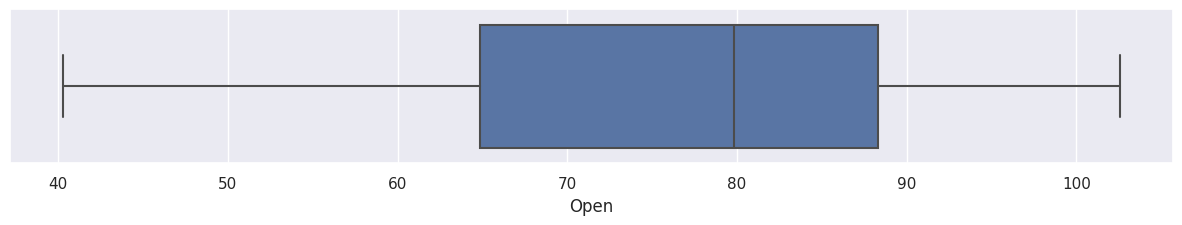

In [22]:
# Checking for the presence of outliers in the data set using box plots.
# Calculated by using the values of Q1,Q2,Q3,IQR=Q3-Q1.
# Lower bound = Q1 - IQR
# Upper bound = Q3 + IQR
# For the Open column
plt.figure(figsize=(15,2))
R1=sns.boxplot(data=train, x='Open')
R1

<Axes: xlabel='Close'>

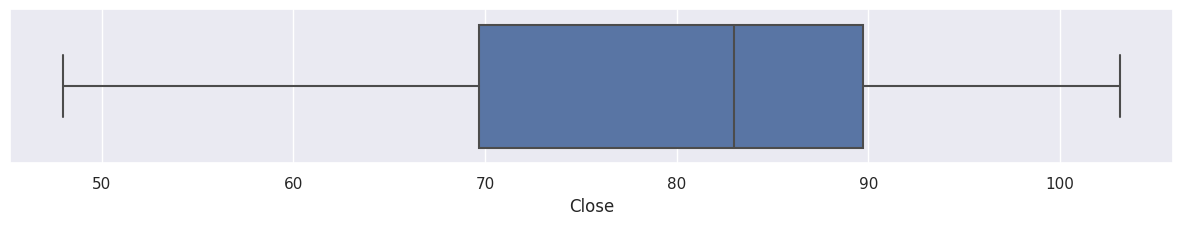

In [23]:
# For the Close column
plt.figure(figsize=(15,2))
R1=sns.boxplot(data=train, x='Close')
R1

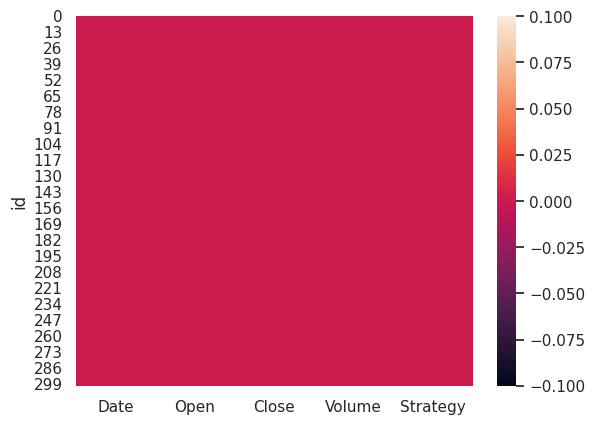

In [24]:
#Heat map to check for the presence of any null values in the train dataset.
sns.heatmap(train.isnull());

## Checking for Class imbalance in Strategy

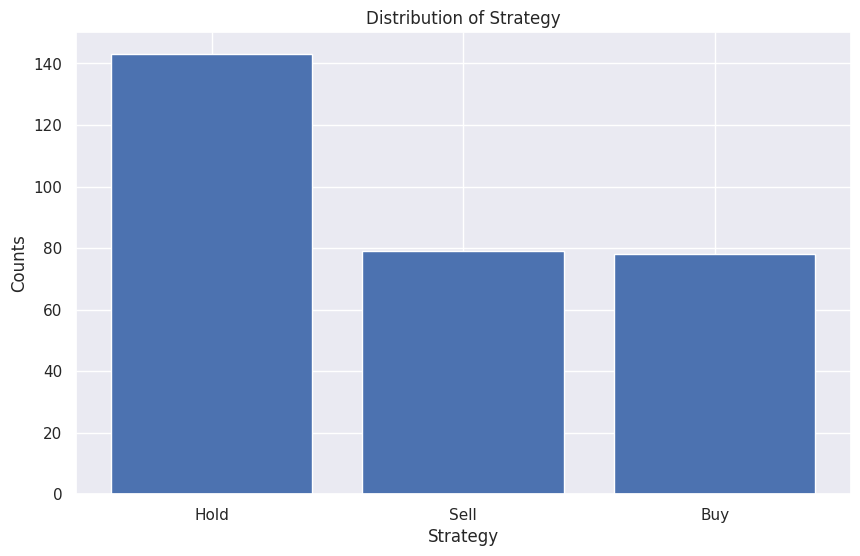

Strategy
Hold    143
Sell     79
Buy      78
Name: count, dtype: int64


In [25]:
import matplotlib.pyplot as plt

# Count the occurrences of each class
class_counts = train['Strategy'].value_counts()

# Plot the distribution of genres
plt.figure(figsize=(10,6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Strategy')
plt.ylabel('Counts')
plt.title('Distribution of Strategy')
plt.show()

print(class_counts)

### The Strategy column is imbalanced

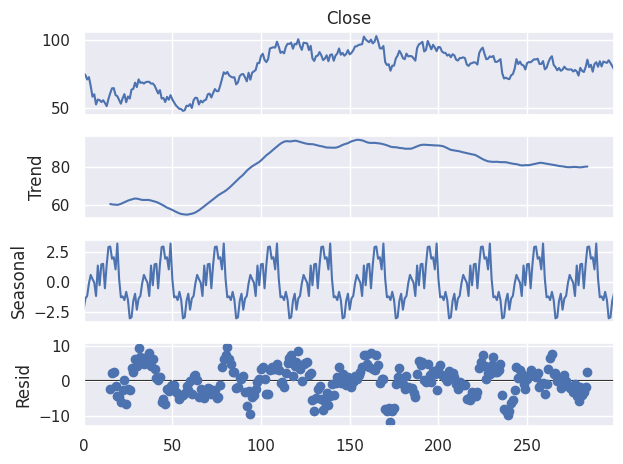

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Perform seasonal decomposition
result = seasonal_decompose(train['Close'], model='additive', period=30) 

# Plot the decomposition
result.plot()
plt.show()

### INFERENCE: From the above graph, we identify the presence of seasonality, trend and residuals in the data set.

#  **FORECASTING SPECIFIC EDA**

## The ADF test is used to determine the presence of a unit root, testing for stationarity. 


### H0 : Suggests that the data is non-stationary, i.e, data contains a unit root. 
### H1 : Suggets that the data is stationary. 

In [27]:
from statsmodels.tsa.stattools import adfuller
test_rest=adfuller(train['Close'])

def adfuller_test(Close):
    result=adfuller(Close)
    labels = ['ADF Test Statistic','p-value','# of Lags Used', '# of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Stationary")
    else:
        print("Non-stationary")
        
adfuller_test(train['Close'])

ADF Test Statistic : -1.8080055426222836
p-value : 0.37649446979222034
# of Lags Used : 1
# of Observations Used : 298
Non-stationary


### p value is >0.05 during the ADF test, series is Non-stationary and it accepts NULL hypothesis

## Differencing the data to convert non stationary data to stationary data.

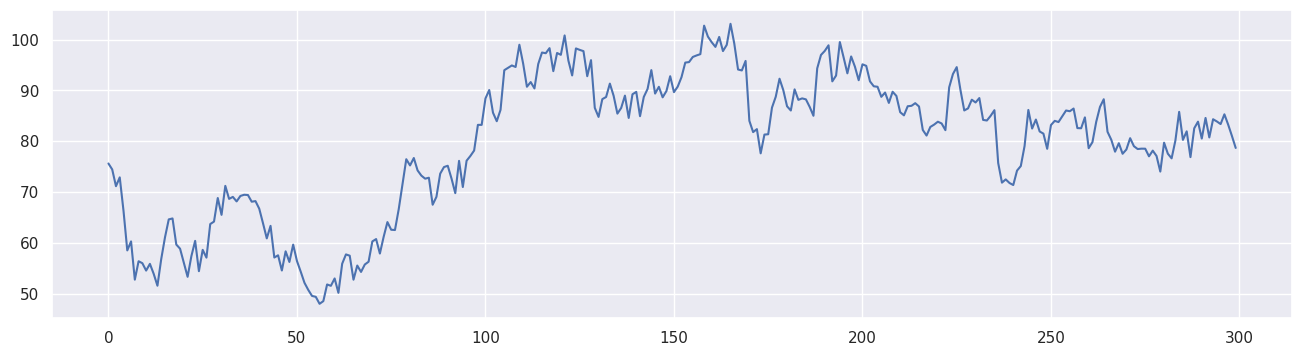

In [28]:
#Graph before differencing.
close=train[['Close']].copy()
graph = close.dropna()
fig, (ax1) = plt.subplots(1,figsize=(16,4))
ax1.plot(graph)

### We observe above graph is non stationary.

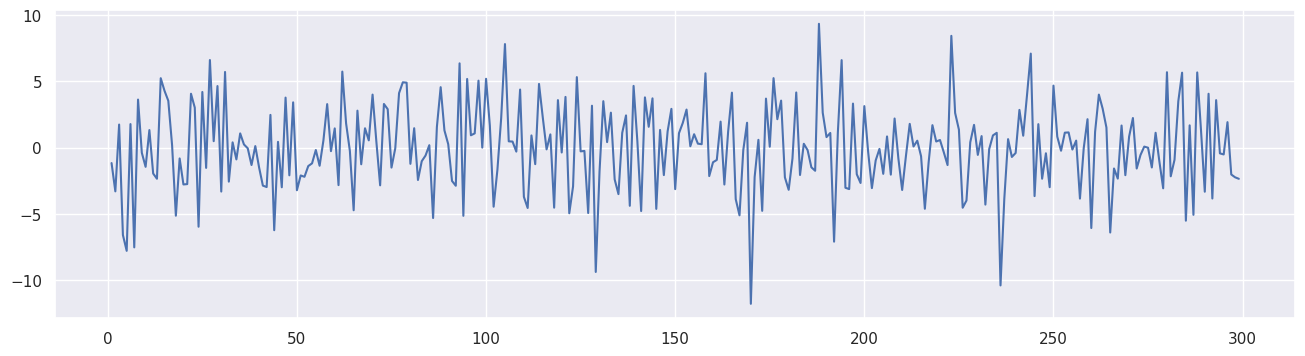

In [29]:
close=train[['Close']].copy()
diff = close.diff().dropna()
fig, (ax1) = plt.subplots(1,figsize=(16,4))
ax1.plot(diff)

### After 1st differencing, the above graph is observed.

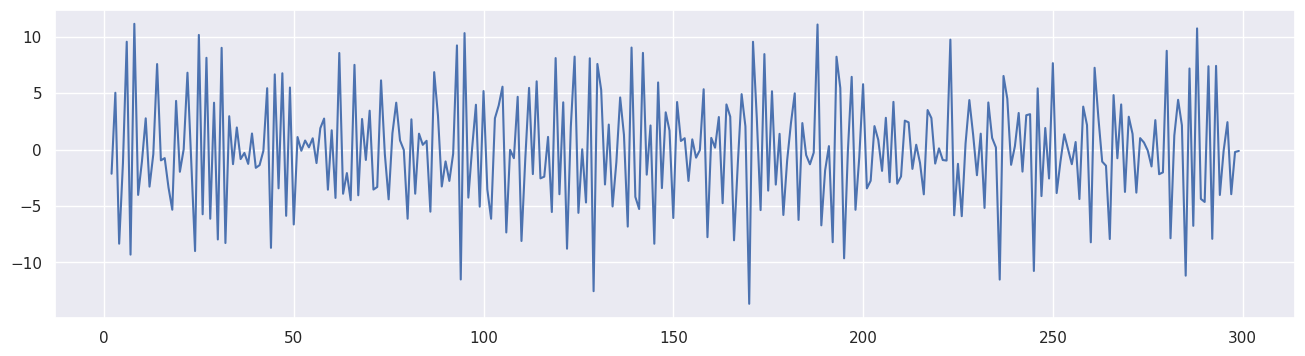

In [30]:
close=train[['Close']].copy()
diff2 = close.diff().diff().dropna()
fig, (ax1) = plt.subplots(1,figsize=(16,4))
ax1.plot(diff2)

### After 2nd differencing, we understand d = 2 successfully converts non stationary data to stationary.

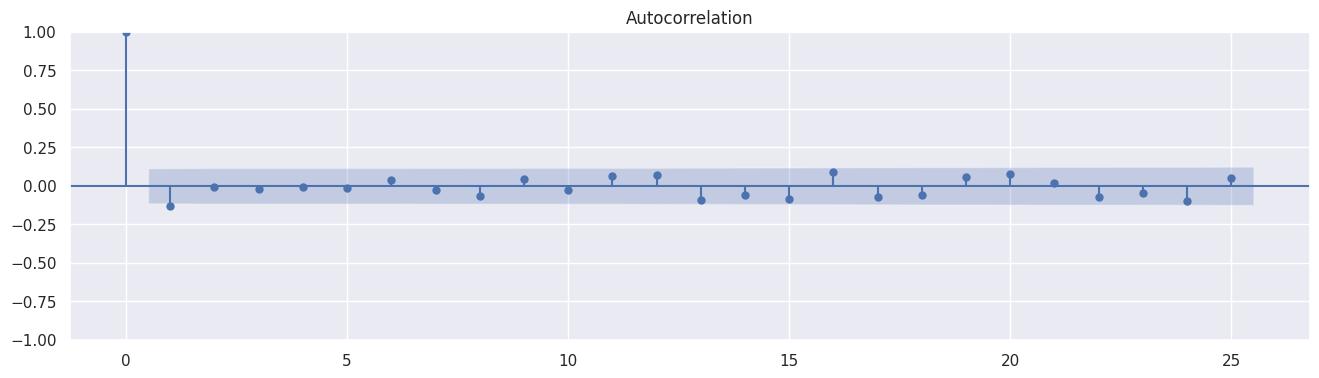

In [31]:
#Plot ACF for q value
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax2) = plt.subplots(1,figsize=(16,4))
plot_acf(diff,ax=ax2);

### ACF graph suggests that optimal q(Moving Average) value is 2.

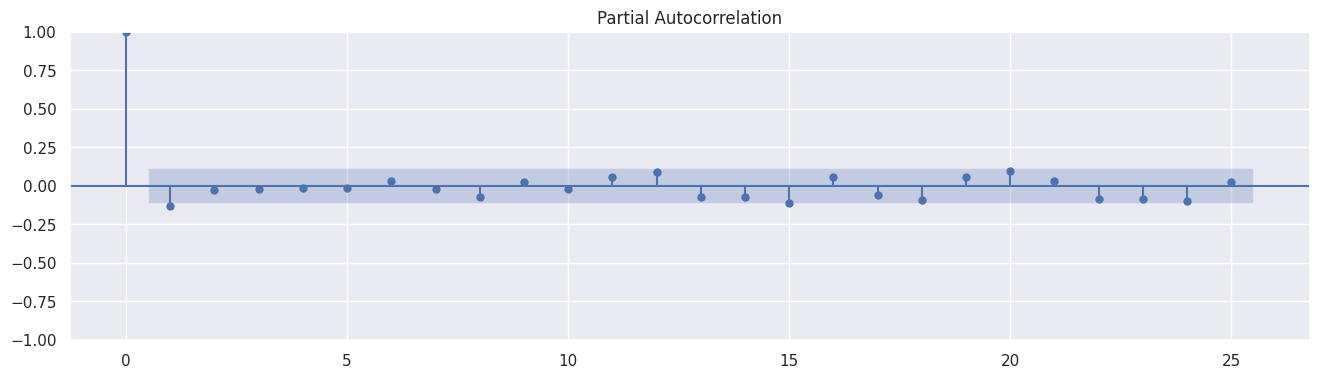

In [32]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, (ax2) = plt.subplots(1,figsize=(16,4))

plot_pacf(diff,ax=ax2);

### PACF graph suggests that optimal p(Auto Regressive) value is 2.

## Since the data contains seasonality and trend, the SARIMA model best fits the data set to predict and forecast the close prices of the stock dataset.

# SARIMAX MODEL

### SARIMAX model incorporates the exogenous variables, which may be hidden but significantly contribute to seasonality and patterns in the data, thereby affecting the final Close predictions.
#### SARIMAX - Seasonal Auto Regressive Integrated Moving Average, Exogeneous variables included

## Parameters of the SARIMAX model
### p = 2, q = 2, d = 2 
### and
### P = 2, Q = 2, D = 2, S = 7(Weekly seasonality)

### This code applies a SARIMAX model to predict stock closing prices. It first removes trend and seasonality components from the training data and fits the SARIMAX model with exogenous variables (Open and Volume). The predicted values are then adjusted by adding back trend and seasonality. Finally, it plots the training and predicted test set closing prices.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


id
0     72.708331
1     73.310886
2     70.610119
3     72.708331
4     73.310886
        ...    
95    59.428165
96    58.417757
97    55.184092
98    57.048622
99    60.569661
Name: Close, Length: 100, dtype: float64


Text(0.5, 1.0, 'Test Set Closing Prices')

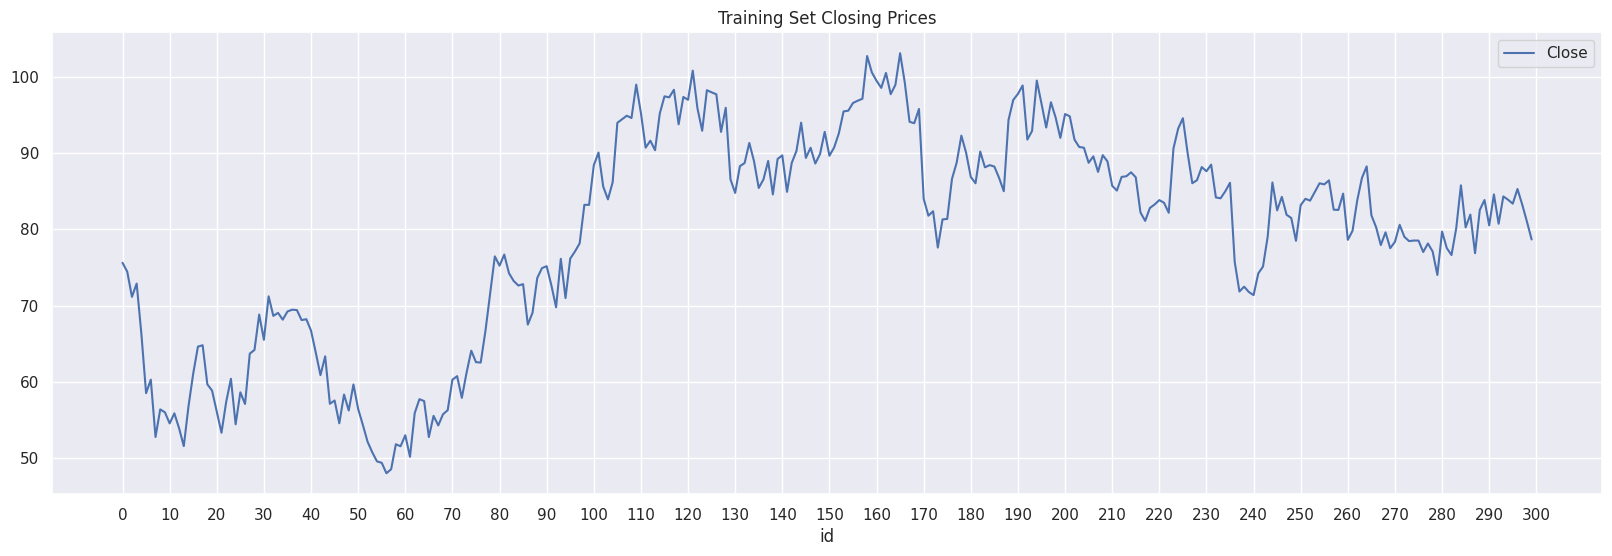

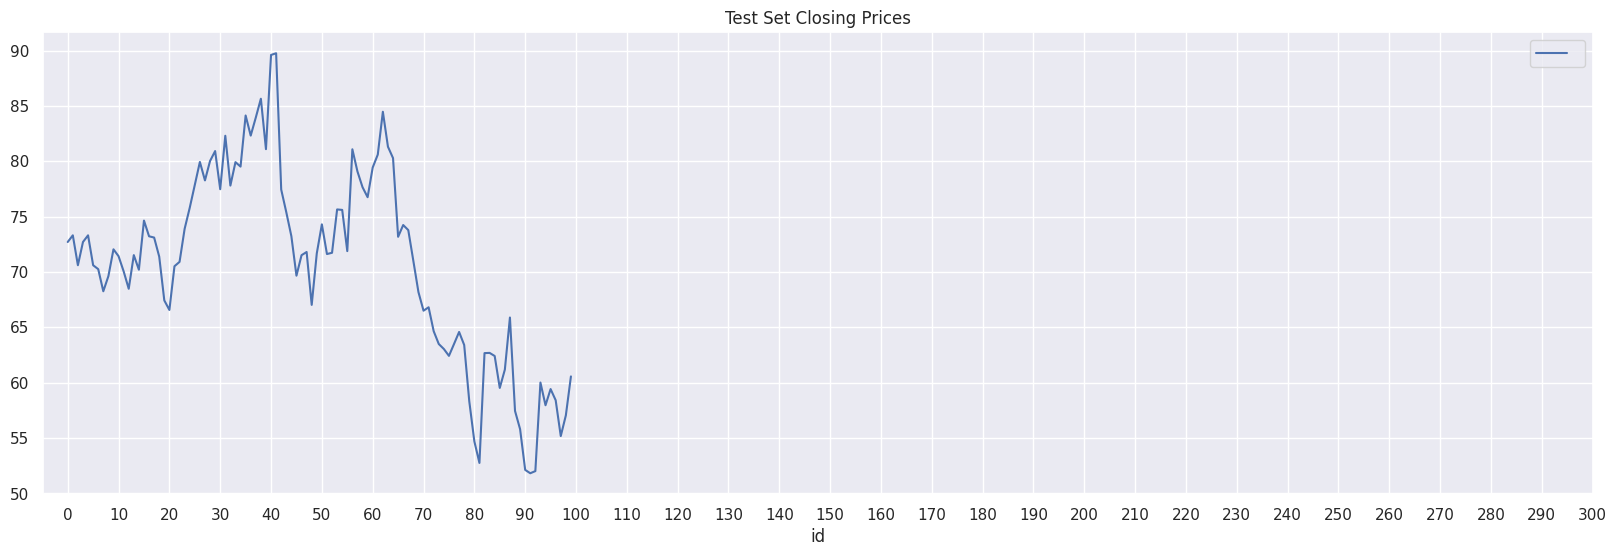

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

test_months = len(test)
training_set = train
test_set = test

# We must first remove the trend and seasonality in the train data inorder to make correct predictions and then later add them back to adjust the magnitude of the forecasted values.
def remove_trend_seasonality(data, period=7):
    decomposition = seasonal_decompose(data, period=period)  # since data set has weekly seasonality
    return data - decomposition.trend - decomposition.seasonal, decomposition.trend, decomposition.seasonal

# Apply the function to the training data
training_set['Adjusted_Close'], trend, seasonal = remove_trend_seasonality(training_set['Close'])

#Target features
training_set['trend'] = trend
training_set['seasonal'] = seasonal

test_set['trend'] = trend
test_set['seasonal'] = seasonal

# Calculate rolling means for Open and Volume
test_set['Open_roll_mean'] = test_set['Open'].rolling(window=7, min_periods=1).mean()
test_set['Volume_roll_mean'] = test_set['Volume'].rolling(window=7, min_periods=1).mean()
training_set['Open_roll_mean'] = training_set['Open'].rolling(window=7, min_periods=1).mean()
training_set['Volume_roll_mean'] = training_set['Volume'].rolling(window=7, min_periods=1).mean()

# Add to features
features = ['Open', 'Volume', 'trend', 'seasonal', 'Open_roll_mean', 'Volume_roll_mean']
test_set[features] = test_set[features].fillna(0).values
training_set[features] = training_set[features].fillna(0).values

# Set the exogenous variables for training and testing
train_exog = training_set[features]
test_exog = test_set[features]

# Fitting SARIMAX model
model = SARIMAX(training_set['Adjusted_Close'], exog=train_exog, order=(2,2,2), seasonal_order=(2, 2, 2, 7))
model_fit = model.fit(disp=False)
# Generating predictions
predictions_sarimax = model_fit.get_prediction(start=test_set.index[0], end=test_set.index[-1], exog=test_exog)
predicted_mean = predictions_sarimax.predicted_mean

# Adding back trend and seasonality to the forecasted values.
Adjusted_Close, trend, seasonal = remove_trend_seasonality(test_set['Open'])
predicted_data_with_seasonality = predicted_mean + trend[-test_months:] + seasonal[-test_months:]

# When we remove the trend and seasonality components, we get NaN values. We're replacing these NaN values with the corresponding Open values.
if predicted_data_with_seasonality.isna().any():
    predicted_data_with_seasonality = test_set['Open']

# To adjust the predicted values to the apt values, to avoid the computational difference due to lag.
predicted_data_shifted = pd.Series(index=predicted_data_with_seasonality.index)
predicted_data_shifted.iloc[3:] = predicted_data_with_seasonality.values[:-3]
predicted_data_shifted.iloc[:3] = test_set['Open'].iloc[:3]

# Adding to test data.
test_set['Close'] = predicted_data_shifted

print(test_set['Close'])

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
training_set['Close'].plot(figsize = (20,6), legend = True)
num_ticks = 30
x_positions = list(range(0, 301, 10))
plt.xticks(x_positions)
plt.title("Training Set Closing Prices")

plt.figure(figsize=(20, 6))
predicted_data_shifted.plot(legend = True)
num_ticks = 30
x_positions = list(range(0, 301, 10))
plt.xticks(x_positions)
plt.title("Test Set Closing Prices")

## Feature Engineering in the above code:
1. Adjusted Close: After removing trend and seasonal components
2. Trend: Trend component of the values.
3. Seasonal : Seasonality component of the values.

# ENSEMBLE OF RANDOM FOREST AND XGBOOST  :  Strategy Classification

### We observed that random forest and xgboost by themselves gave a decent accuracy but not a promising one.
### Hence we chose to perform ensemble learning for classification.

### Random Forest can handle multi-class classification and here we need to predict: Buy, Sell or Hold.
### Xgboost performs effective handling of imbalanced data (as observed in  data visualisation)
### Features used: Open, Close, Volume, trend, seasonal, Open_roll_mean, Volume_roll_mean. as these were likely to have an impact on the target variable (Strategy)

### To correctly classify the over bought and over sold stocks, we use RSI(Relative Strength Index) to classify. This adds to feature engineering.

In [34]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Default strategy is set to Hold
test_set['Strategy'] = 'Hold'

# Chosen features 
features = ['Open', 'Close', 'Volume', 'trend', 'seasonal', 'Open_roll_mean', 'Volume_roll_mean']

# Handling NaN values
test_set[features]=test_set[features].fillna(0).values

X_train = training_set[features].fillna(0).values
y_train = training_set['Strategy']
X_test = test_set[features].fillna(0).values
y_test = test_set['Strategy']

# Training the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)

# Encode the target labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Training the XGBoost Classifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train_encoded)







ensemble_model = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model)], voting='soft')
ensemble_model.fit(X_train, y_train_encoded)

# Generating predictions with the ensemble
predictions_ensemble = le.inverse_transform(ensemble_model.predict(X_test))

test_set['Strategy']= predictions_ensemble

print(test_set['Strategy'])




# RSI: Relative Strength Index
def calculate_rsi(data, window_length=14):
    close_prices = data
    delta = close_prices.diff()
    gain = delta.mask(delta < 0, 0)
    loss = -delta.mask(delta > 0, 0)

    average_gain = gain.rolling(window=window_length, min_periods=1).mean()
    average_loss = loss.rolling(window=window_length, min_periods=1).mean()

    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

test_set['RSI'] = calculate_rsi(test_set['Close'])

# Boundary conditions for RSI, to understand over bought and over sold zone.
rsi_condition = (test_set['RSI'] <= 40) | (test_set['RSI'] >= 60)

if rsi_condition.any():
    test_set.loc[(test_set['RSI'] <= 40), 'Strategy'] = 'Buy'
    test_set.loc[(test_set['RSI'] >= 60), 'Strategy'] = 'Sell'

print(test_set['Strategy'])




id
0      Buy
1      Buy
2     Hold
3      Buy
4      Buy
      ... 
95    Hold
96    Hold
97    Sell
98    Hold
99    Sell
Name: Strategy, Length: 100, dtype: object
id
0      Buy
1     Sell
2      Buy
3      Buy
4      Buy
      ... 
95    Hold
96    Hold
97    Sell
98    Hold
99    Sell
Name: Strategy, Length: 100, dtype: object


## Feature Engineering:
### Post adding the adjusted close, trend and season components, we now add the RSI component to the test set.
4. RSI (Relative Strength Index)

## Why RSI?
### RSI can be used to confirm the strength of an existing trend. If RSI is rising along with the stock's price, it suggests that the uptrend is strong. Conversely, if RSI is declining while the price is falling, it may indicate a strong downtrend.

### Divergence Analysis: RSI can be used to identify divergence between price and the indicator,here strategy. When the price is making higher highs while RSI is making lower highs, or vice versa, it can be a sign of potential trend reversal.

## Graph showing the Buy and Sell signals.

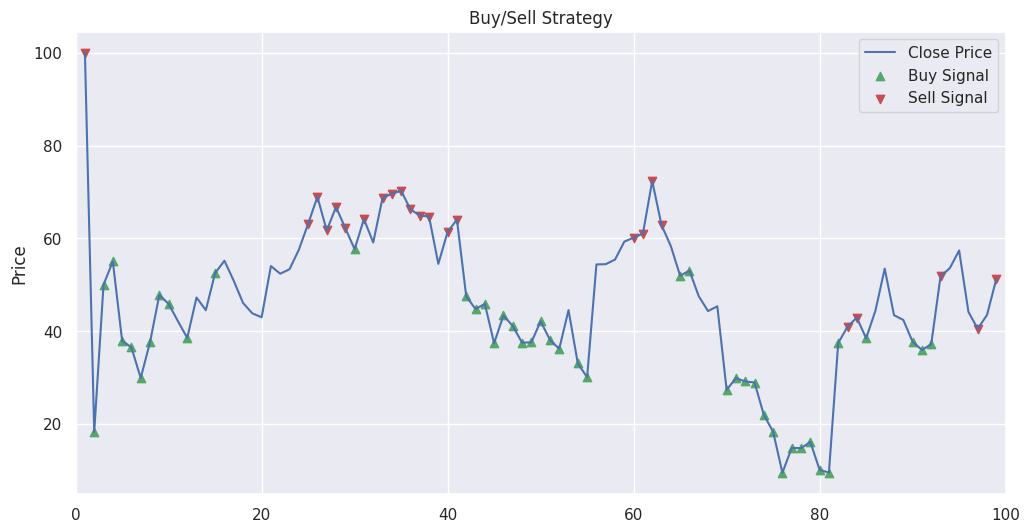

In [35]:
import matplotlib.pyplot as plt

# Plotting Strategy
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['RSI'], label='Close Price')
plt.scatter(test[test['Strategy'] == 'Buy'].index, test[test['Strategy'] == 'Buy']['RSI'], marker='^', color='g', label='Buy Signal')
plt.scatter(test[test['Strategy'] == 'Sell'].index, test[test['Strategy'] == 'Sell']['RSI'], marker='v', color='r', label='Sell Signal')
plt.title('Buy/Sell Strategy')
plt.ylabel('Price')
plt.xlim(0, len(test.index))
plt.legend()
plt.show()


## Submission

In [36]:
import pandas as pd

# Generate the 'id' column with values from 0 to 99
ids = list(range(100))

# Assuming 'test' and 'predictions_sarimax' are defined
submission_data = pd.DataFrame({
    'id': ids,
    'Date': test['Date'],
    'Close': test_set['Close'],  # Assuming the predictions are stored in index 1
    'Strategy': test_set['Strategy']
})

# Save the submission DataFrame to a CSV file
submission_data.to_csv('submission.csv', index=False)

# Print the submission DataFrame
print("Submission Data:")
print(submission_data)


Submission Data:
    id        Date      Close Strategy
id                                    
0    0  2021-03-01  72.708331      Buy
1    1  2021-03-08  73.310886     Sell
2    2  2021-03-15  70.610119      Buy
3    3  2021-03-22  72.708331      Buy
4    4  2021-03-29  73.310886      Buy
..  ..         ...        ...      ...
95  95  2022-12-26  59.428165     Hold
96  96  2023-01-02  58.417757     Hold
97  97  2023-01-09  55.184092     Sell
98  98  2023-01-16  57.048622     Hold
99  99  2023-01-23  60.569661     Sell

[100 rows x 4 columns]
